This is Dedalus script that computes the eigenmodes of waves on a clamped string. It demonstrates solving a 1D eigenvalue problem and produces plots of the first few eigenmodes and the relative error of the eigenvalues. It should take just a few seconds to run (serial only).

We will use a Legendre basis to solve the EVP:

$$
s u + \partial_{xx}u =0,\\
u(0) = 0,\\
u(Lx) = 0,
$$

where $s$ is the eigenvalue and $Lx$ the string length.

For the second derivative on a closed interval, we need two tau terms. Here we choose to use a first-order formulation, putting one tau term on an auxiliary first-order variable and another in the PDE, and lifting both to the first derivative basis.

In [1]:
#Here we load in the necessary dedalus modules, numpy and matplotlib.
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3

2023-03-01 01:27:59,642 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2023-03-01 01:27:59,645 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2023-03-01 01:27:59,770 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [2]:
# Parameters
Lx = 1 #Size of the domain
Nx = 128 #Number of Chebyshev modes (this is dealiased by 3/2 by default to 192.
dtype = np.complex128 #This is a complex eigenproblem.

In [3]:
# Bases
xcoord = d3.Coordinate('x') #Set up coordinate metadata and labels.
dist = d3.Distributor(xcoord, dtype=dtype) #Set up the internals associated with MPI 
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(0, Lx)) #Define the basis on the coordinate.

In [4]:
# Fields
u = dist.Field(name='u', bases=xbasis) #Create a field to represent our eigenvectors over this basis
tau_1 = dist.Field(name='tau_1') #Create taus for the left and right boundaries.
tau_2 = dist.Field(name='tau_2')
s = dist.Field(name='s') #Our scalar eigenvalue

In [5]:
# Substitutions
dx = lambda A: d3.Differentiate(A, xcoord) #Set up a differentiation operator on the coordinate
lift_basis = xbasis.derivative_basis(1) #This will be used to account for our boundary conditions on the first derivative basis of the Legendre polynomials.
lift = lambda A: d3.Lift(A, lift_basis, -1) #Set up a simplified tau lift operator.
ux = dx(u) + lift(tau_1) # First-order reduction
uxx = dx(ux) + lift(tau_2) # Second derivative.

In [6]:
# Problem
problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals()) #Create an eigenproblem type
problem.add_equation("s*u + uxx = 0") #Our desired wave equation
problem.add_equation("u(x=0) = 0") # Left boundary associated with tau_1
problem.add_equation("u(x=Lx) = 0") # Right boundary associated with tau_2

{'LHS': interp(<Field 140538771617296>, x=1),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'M': 0,
 'L': interp(<Field 140538771617296>, x=1),
 'domain': <dedalus.core.domain.Domain at 0x7fd1bb8f3c50>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [7]:
# Solve
solver = problem.build_solver() #Build the matrices for the problem given our operators and lifted taus.
solver.solve_dense(solver.subproblems[0]) #Do a dense QZ solve for all the eigenvalues for our problem size (Nx values)
evals = np.sort(solver.eigenvalues)
n = 1 + np.arange(evals.size)
true_evals = (n * np.pi / Lx)**2
relative_error = np.abs(evals - true_evals) / true_evals #Compare against the analytical eigenvalues.

2023-03-01 01:28:00,207 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s


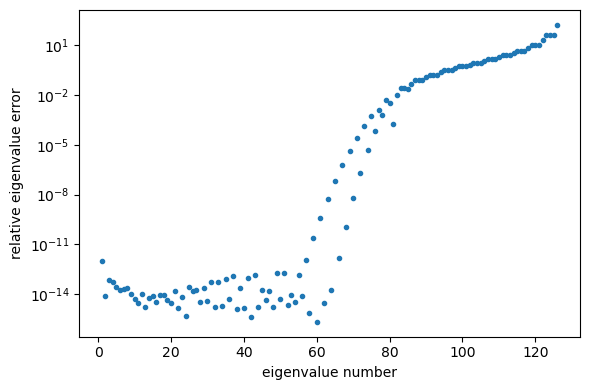

In [8]:
# Plot
plt.figure(figsize=(6, 4))
plt.semilogy(n, relative_error, '.')
plt.xlabel("eigenvalue number")
plt.ylabel("relative eigenvalue error")
plt.tight_layout()
plt.savefig("eigenvalue_error.pdf")
plt.savefig("eigenvalue_error.png", dpi=200)

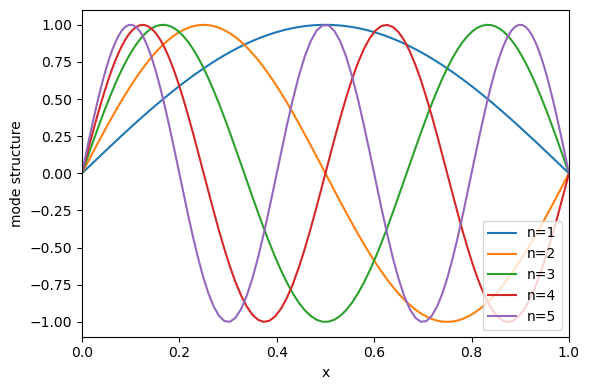

In [9]:
plt.figure(figsize=(6, 4))
x = dist.local_grid(xbasis)
for n, idx in enumerate(np.argsort(solver.eigenvalues)[:5], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = (u['g'] / u['g'][1]).real
    plt.plot(x, ug/np.max(np.abs(ug)), label=f"n={n}")
plt.xlim(0, 1)
plt.legend(loc="lower right")
plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
plt.savefig("eigenvectors.pdf")
plt.savefig("eigenvectors.png", dpi=200)

Ok that was easy.  Let's add in some non-constant coefficients (NCCs), like changing the mass or tension of the string as a function of position. So, let's solve:

$$
s \mu(x) u + \partial_{xx}u =0,\\
u(0) = 0,\\
u(Lx) = 0,
$$

where $\mu(x) = e^{-10x}$

In [16]:
#Let's define a function that solves this problem and returns a set of eigenvalues and eigenvectors.
def WaveEigenproblem(Nx):
    # Parameters
    Lx = 1
    dtype = np.complex128

    # Bases
    xcoord = d3.Coordinate('x')
    dist = d3.Distributor(xcoord, dtype=dtype)
    xbasis = d3.Legendre(xcoord, size=Nx, bounds=(0, Lx))

    # Fields
    u = dist.Field(name='u', bases=xbasis)
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    s = dist.Field(name='s')

    # Mass Field
    x = dist.local_grid(xbasis)
    mu = dist.Field(name='mu', bases=xbasis) #Create a field to represent our mass over this basis
    mu['g'] = np.exp(-10*x) #Assign values on the grid

    # Substitutions
    dx = lambda A: d3.Differentiate(A, xcoord)
    lift_basis = xbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)
    ux = dx(u) + lift(tau_1) # First-order reduction
    uxx = dx(ux) + lift(tau_2)

    # Problem
    problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
    problem.add_equation("s*mu*u + uxx = 0")
    problem.add_equation("u(x=0) = 0")
    problem.add_equation("u(x=Lx) = 0")

    # Solve
    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0])
    eigs = solver.eigenvalues
    vecs = np.zeros((Nx,len(eigs)),dtype=np.float64)
    for ii in range(len(eigs)):
        solver.set_state(ii, solver.subsystems[0])
        vecs[:,ii] = (u['g'] / u['g'][1]).real
    return eigs, vecs, x

2023-03-01 01:29:34,856 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


/tmp/ipykernel_471036/3471062879.py:43: RuntimeWarning: invalid value encountered in divide
  vecs[:,ii] = (u['g'] / u['g'][1]).real


2023-03-01 01:29:36,685 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.0e+00/s


Text(0, 0.5, '$1/\\delta$')

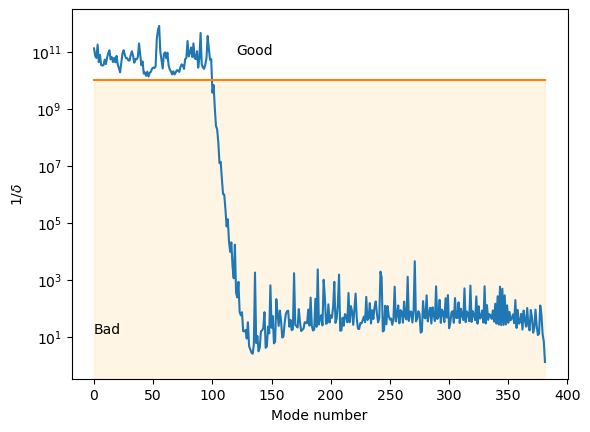

In [17]:
#Let's find how many eigenmodes are converged for Nx=128
#Delta rejection algorithm from Boyd, compare spectra at two resolutions.
eigs1, vecs1, x1 = WaveEigenproblem(384) #Problem at Nx=128
eigs2, vecs2, x22 = WaveEigenproblem(512) #Problem at Nx=256

#Remove infinite eigenvalues
if1 = np.isfinite(eigs1)
eigs1 = eigs1[if1]
vecs1 = vecs1[:,if1]
if2 = np.isfinite(eigs2)
eigs2 = eigs2[if2]
vecs2 = vecs2[:,if2]

ieigs1 = np.argsort(eigs1.real) #Sort them
ieigs2 = np.argsort(eigs2.real)

#Sorted arrays
eigs1 = eigs1[ieigs1]
vecs1 = vecs1[:,ieigs1]
eigs2 = eigs2[ieigs2]
vecs2 = vecs2[:,ieigs2]

#Find distance between the sorted eigenvalues
ne1 = len(eigs1)
ne2 = len(eigs2)
sigma = 0*eigs1
sigma[0] = np.abs(eigs1[0]-eigs1[1])
sigma[1:ne1-1] = 0.5*(np.abs(eigs1[1:ne1-1]-eigs1[0:ne1-2])+np.abs(eigs1[2:ne1]-eigs2[1:ne1-1]))
sigma[ne1-1] = np.abs(eigs1[ne1-1]-eigs1[ne1-2])

#Find the weighted distance between eigenvalues between the two resolutions.
delta = 0*sigma
for jj in range(ne1):
    delta[jj] = np.min(np.abs(eigs1[jj]-eigs2))/sigma[jj]

fig, ax = plt.subplots()
ax.plot(1e0/delta.real)
ax.plot(0*delta.real+1e10)
ax.fill_between(np.arange(len(delta)),0*delta.real+1e10,0,alpha=0.1,color='orange')
ax.text(120,np.max(1/delta.real)/10,'Good')
ax.text(0,np.min(1/delta.real)*10,'Bad')
ax.set_yscale('log')
ax.set_xlabel('Mode number')
ax.set_ylabel(r'$1/\delta$')

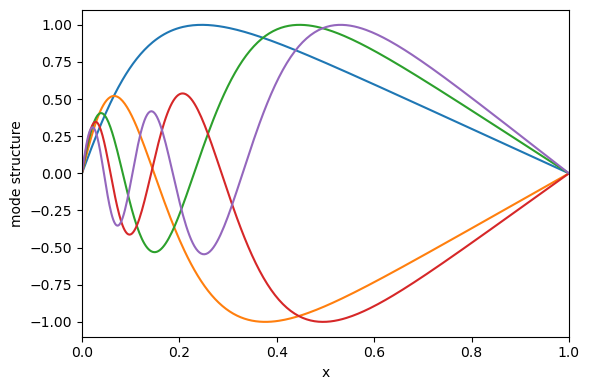

In [18]:
plt.figure(figsize=(6, 4))

for n in range(5):
    ug = vecs1[:,n]
    ug = ug/np.max(np.abs(ug))
    plt.plot(x1, ug, label=f"n={n}")
plt.xlim(0, 1)

plt.ylabel(r"mode structure")
plt.xlabel(r"x")
plt.tight_layout()
plt.savefig("eigenvectors.pdf")
plt.savefig("eigenvectors.png", dpi=200)